In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [5]:
from google.colab import files
uploaded = files.upload()

Saving Dataset_smart_streetlight.csv to Dataset_smart_streetlight (1).csv


In [7]:
data_path = "/content/Dataset_smart_streetlight.csv"

In [8]:
data = pd.read_csv(data_path)
data.head(5)

,Time,Weather,Battery,Motion,Traffic,AmbientLight,SolarOutput,Light
0,Night,Rainy,Medium,No,High,74,0.70,On
1,Night,Cloudy,High,Yes,High,32,3.95,On
2,Morning,Sunny,Medium,No,High,346,8.05,On
3,Afternoon,Rainy,Low,Yes,Medium,666,1.37,Dim
4,Evening,Rainy,Medium,No,Low,124,2.59,Off


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Time          1500 non-null   object 
 1   Weather       1500 non-null   object 
 2   Battery       1500 non-null   object 
 3   Motion        1500 non-null   object 
 4   Traffic       1500 non-null   object 
 5   AmbientLight  1500 non-null   int64  
 6   SolarOutput   1500 non-null   float64
 7   Light         1500 non-null   object 
dtypes: float64(1), int64(1), object(6)
memory usage: 93.9+ KB


In [11]:
data.describe()

,AmbientLight,SolarOutput
count,1500.000000,1500.000000
mean,374.674000,4.735393
std,291.189609,2.811714
min,0.000000,0.010000
25%,100.000000,2.377500
50%,302.500000,4.535000
75%,594.500000,7.060000
max,1000.000000,9.990000


In [10]:
#Split into features and target
x = data.drop('Light', axis=1)
y = data['Light']

In [12]:
#define the column types
cat_cols = ['Time', 'Weather', 'Battery', 'Motion', 'Traffic']
num_cols = ['AmbientLight', 'SolarOutput']


In [13]:
# What is happening here is we onehot encode the categortical data
# and we standardized the numerical data
# OneHotEncoder(handle_unknown='ignore' takes care of any unknown value
# or anything that is not consistent with what is in the  column
preprocess = ColumnTransformer(
    [
     ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
     ('num', StandardScaler(), num_cols)
    ]
)

In [14]:
# the class weight handles all forms of imbalanced ddata in out dataset
model = Pipeline(
    [
     ('preprocess', preprocess),
     ('classifier', DecisionTreeClassifier(class_weight='balanced', max_depth=4, random_state=42))
    ]
)

In [15]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [16]:
model.fit(x_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Time', 'Weather', 'Battery',
                                                   'Motion', 'Traffic']),
                                                 ('num', StandardScaler(),
                                                  ['AmbientLight',
                                                   'SolarOutput'])])),
                ('classifier',
                 DecisionTreeClassifier(class_weight='balanced', max_depth=4,
                                        random_state=42))])

In [17]:
y_pred = model.predict(x_test)

In [18]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {round(accuracy*100, 2)}%" )

Accuracy: 94.0%


In [19]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         Dim       0.59      1.00      0.74        17
         Off       0.96      0.94      0.95       161
          On       1.00      0.93      0.97       122

    accuracy                           0.94       300
   macro avg       0.85      0.96      0.88       300
weighted avg       0.96      0.94      0.94       300



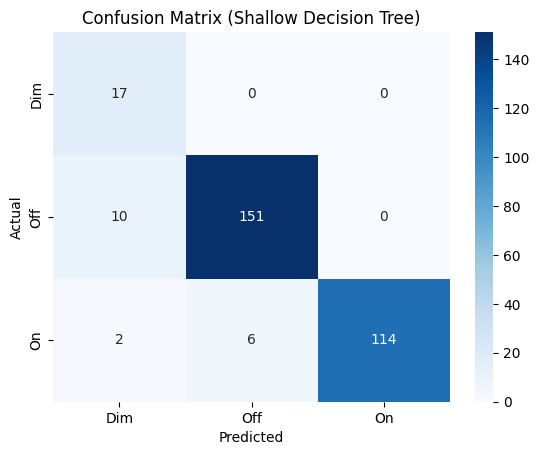

In [20]:
cm = confusion_matrix(y_test, y_pred)
plt.figure()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=model.named_steps['classifier'].classes_,
            yticklabels=model.named_steps['classifier'].classes_)
plt.title("Confusion Matrix (Shallow Decision Tree)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [21]:
feature_names = model.named_steps['preprocess'].get_feature_names_out().tolist()
importances = model.named_steps['classifier'].feature_importances_

In [22]:
imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
imp_df = imp_df.sort_values(by='Importance', ascending=False)

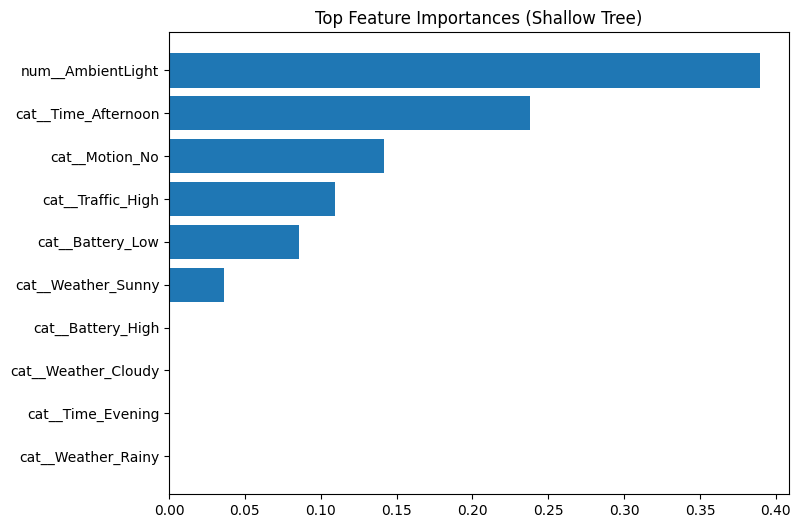

In [23]:
plt.figure(figsize=(8,6))
plt.barh(imp_df['Feature'][:10], imp_df['Importance'][:10])
plt.title("Top Feature Importances (Shallow Tree)")
plt.gca().invert_yaxis()
plt.show()

In [24]:
print("\n--- Feature Importance Table ---\n")
print(imp_df.head(12))


--- Feature Importance Table ---

                Feature    Importance
15    num__AmbientLight  3.893188e-01
0   cat__Time_Afternoon  2.377416e-01
10       cat__Motion_No  1.416396e-01
12    cat__Traffic_High  1.093324e-01
8      cat__Battery_Low  8.581428e-02
6    cat__Weather_Sunny  3.615333e-02
7     cat__Battery_High  5.712894e-15
4   cat__Weather_Cloudy  0.000000e+00
1     cat__Time_Evening  0.000000e+00
5    cat__Weather_Rainy  0.000000e+00
2     cat__Time_Morning  0.000000e+00
3       cat__Time_Night  0.000000e+00


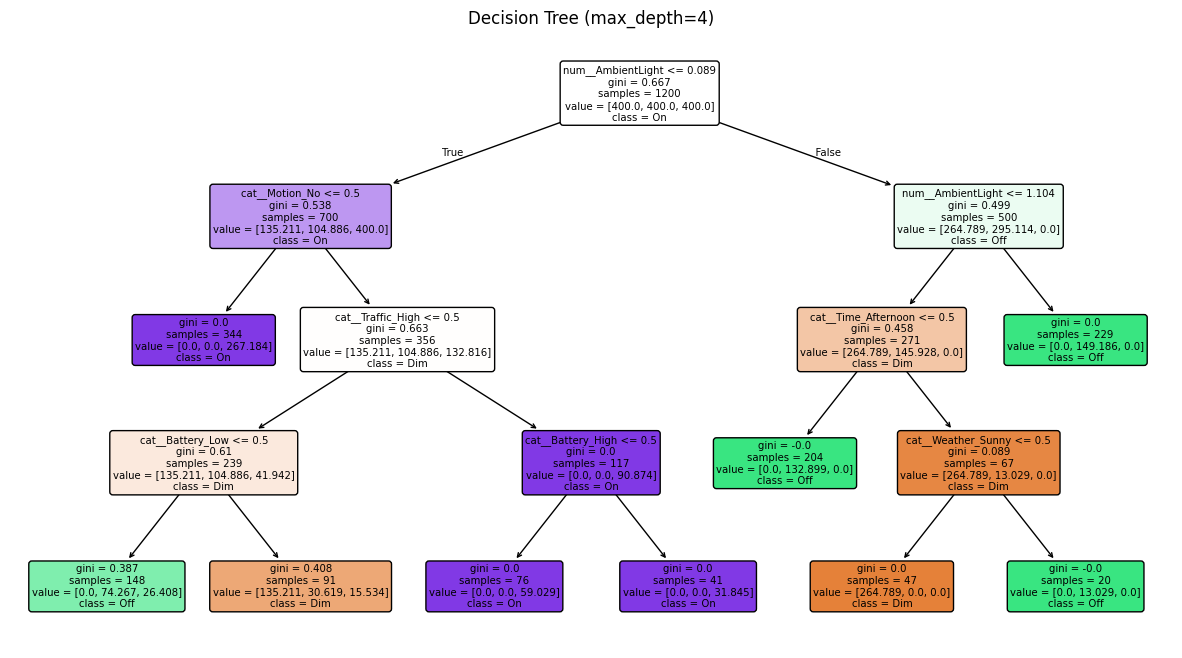

In [25]:
plt.figure(figsize=(15,8))
plot_tree(model.named_steps['classifier'],
          feature_names=feature_names,
          class_names=model.named_steps['classifier'].classes_,
          filled=True,
          rounded=True)
plt.title("Decision Tree (max_depth=4)")
plt.show()

#DEPLOYMENT

In [27]:
import joblib
joblib.dump(model, 'Dataset_smart_streetlight.pkl')

from google.colab import files
files.download("Dataset_smart_streetlight.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>